<center><h1>Image preprocessing demo</h1></center>

## Imports

In [12]:
import os
import glob

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage import measure, morphology, feature
from scipy.ndimage import distance_transform_edt, label, gaussian_gradient_magnitude, maximum_filter
from skimage.segmentation import watershed, random_walker, morphological_chan_vese, morphological_geodesic_active_contour

from hep2_classification.presentation import display_grid, ImagePlotter, HistogramPlotter, LayerPlotter, RANDOM_CMAP
from hep2_classification.preprocessing import preprocess

## Settings

In [2]:
paths = list(sorted(glob.glob('data/samples/*.*')))
titles = [os.path.splitext(os.path.basename(p))[0] for p in paths]

## Load data

In [3]:
imgs = [preprocess(cv.imread(p)) for p in paths]
display_grid(imgs, ImagePlotter(), titles)

---
## Segmentation steps
### Adaptive kernel

In [4]:
def apply_adaptive_kernel(img, kernel, min_avg=100, max_avg=120, min_delta=400, max_delta=2200):
    
    while max_delta - min_delta > 50:
        avg_delta = (min_delta + max_delta) / 2.0
        kerneled = cv.filter2D(img, -1, kernel, delta=-avg_delta)
        avg = np.average(kerneled)
        
        if avg > max_avg:
            min_delta = avg_delta
        elif avg < min_avg:
            max_delta = avg_delta
        else:
            return kerneled
            
    raise ValueError('Failed to find kernel in given delta range')

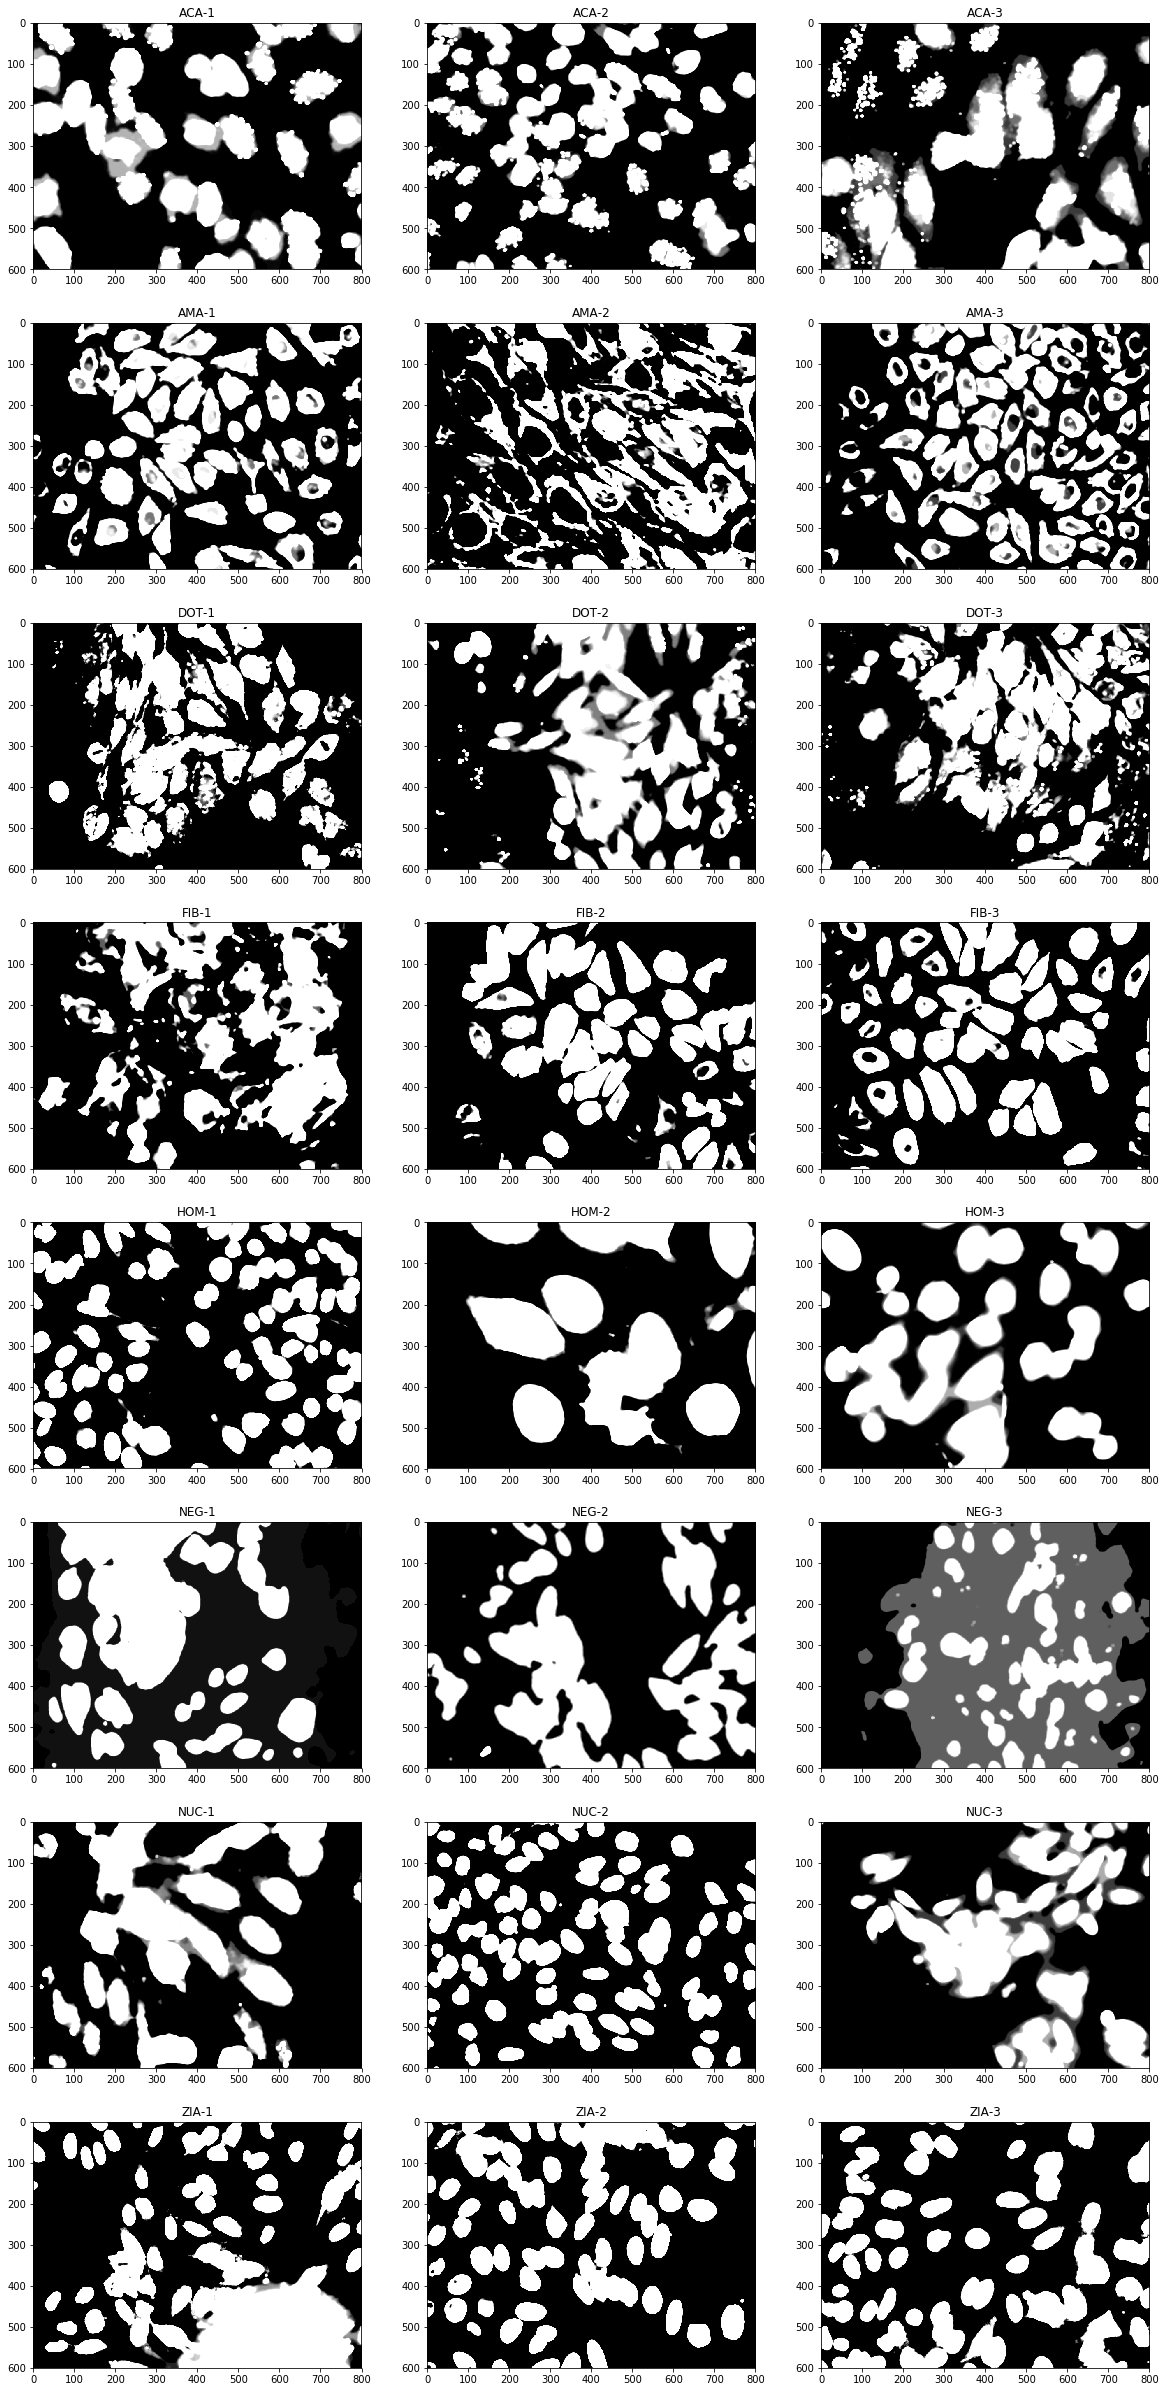

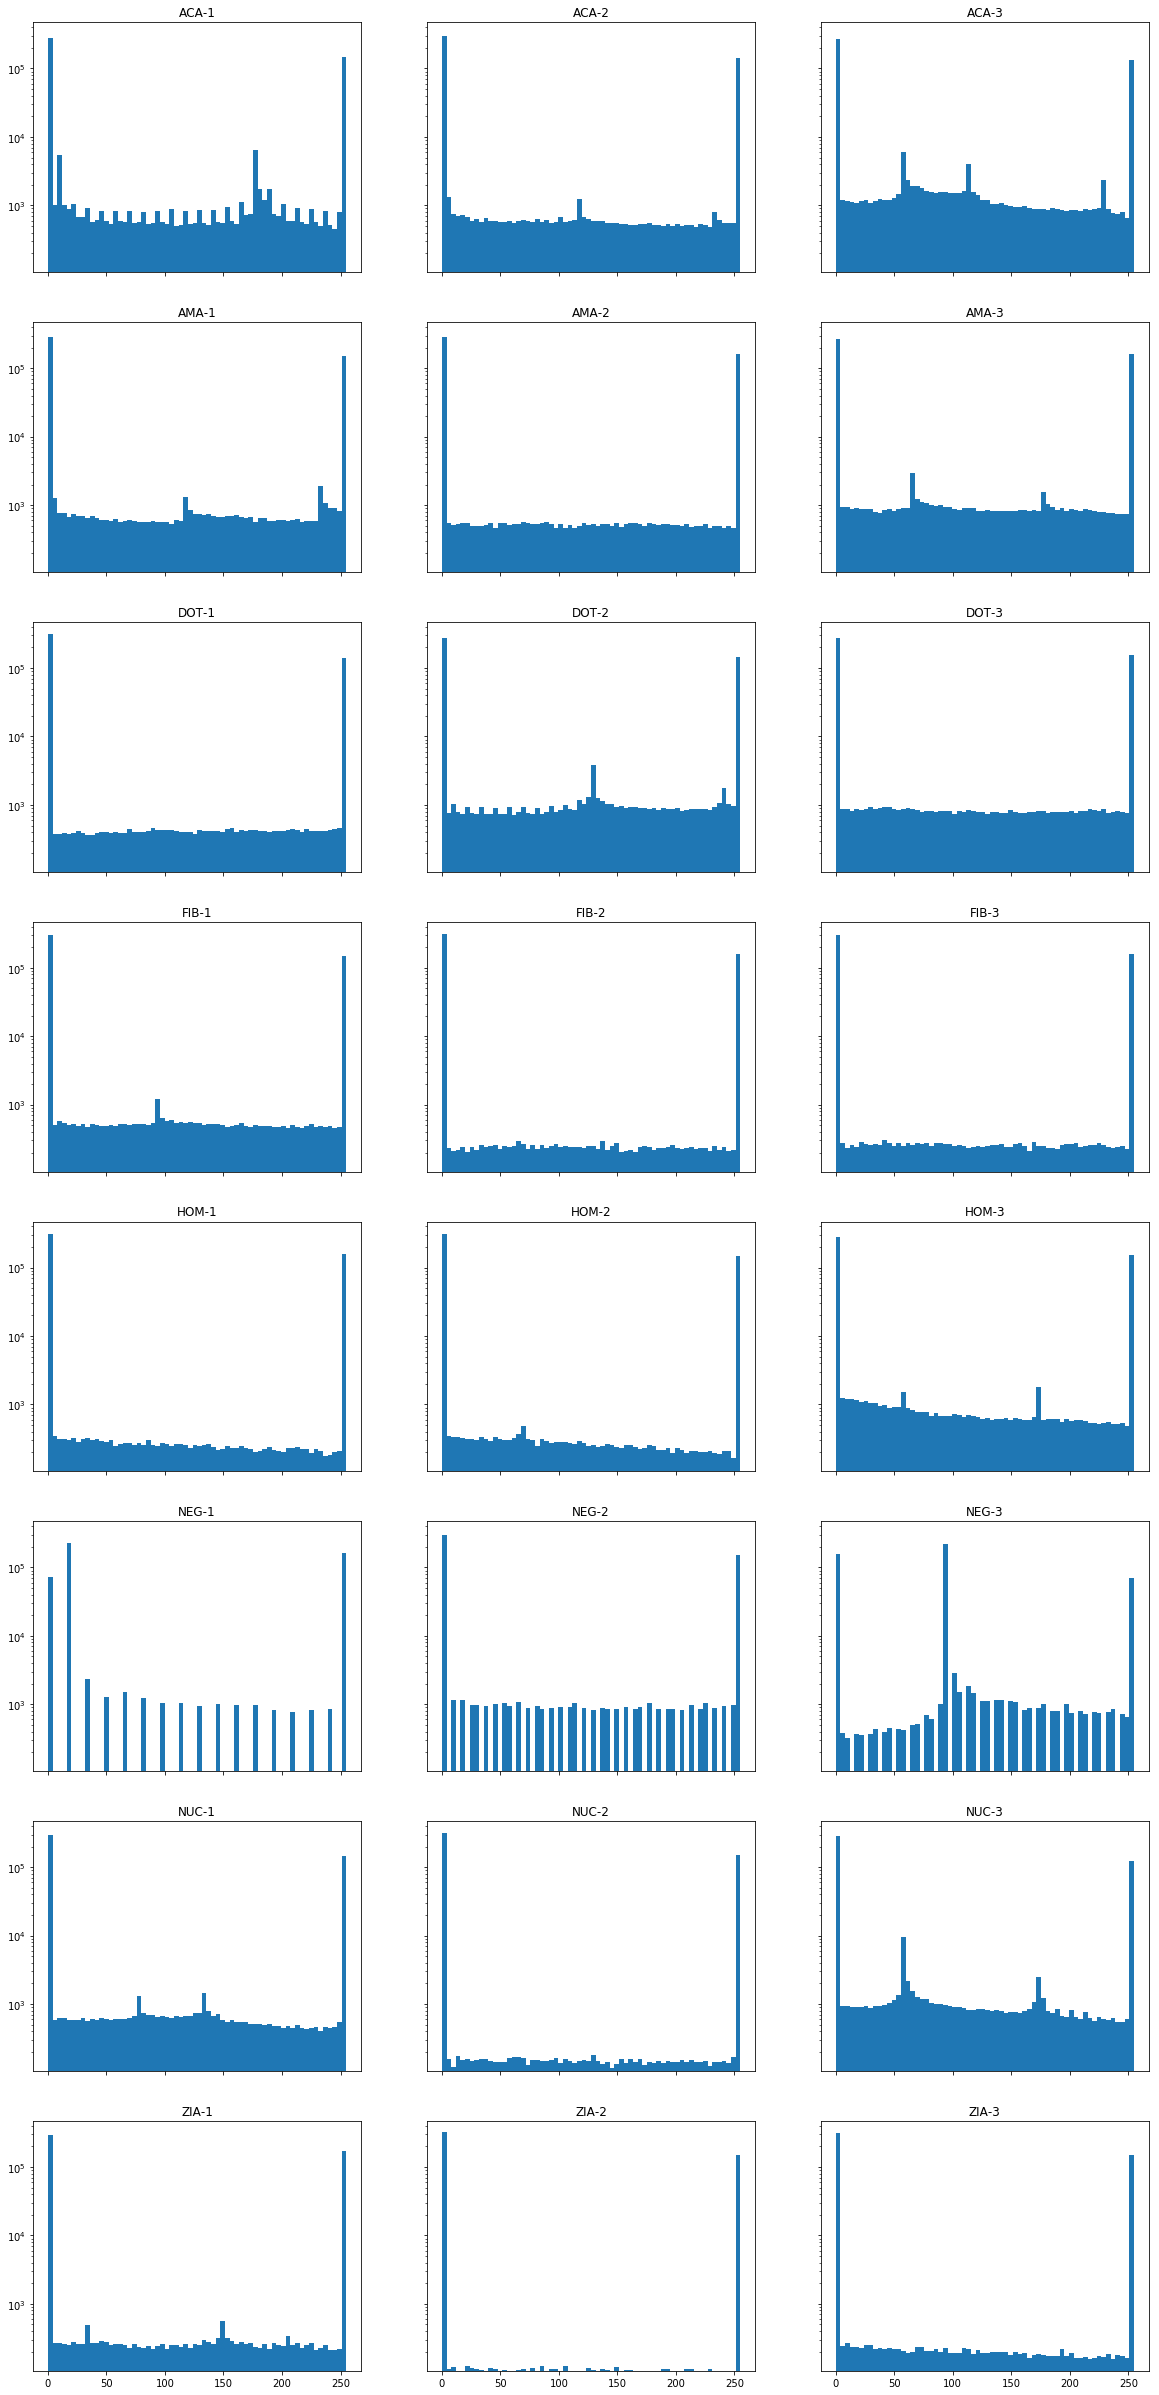

In [5]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (9,9))
imgs_kernel = [apply_adaptive_kernel(img, kernel, min_avg=80, max_avg=100, max_delta=4000) for img in imgs]
# imgs_kernel = [cv.filter2D(img, -1, kernel, delta=-1000) for img in imgs]
display_grid(imgs_kernel, ImagePlotter(), titles)
display_grid(imgs_kernel, HistogramPlotter(), titles, sharey=True, sharex=True)

### Threshold

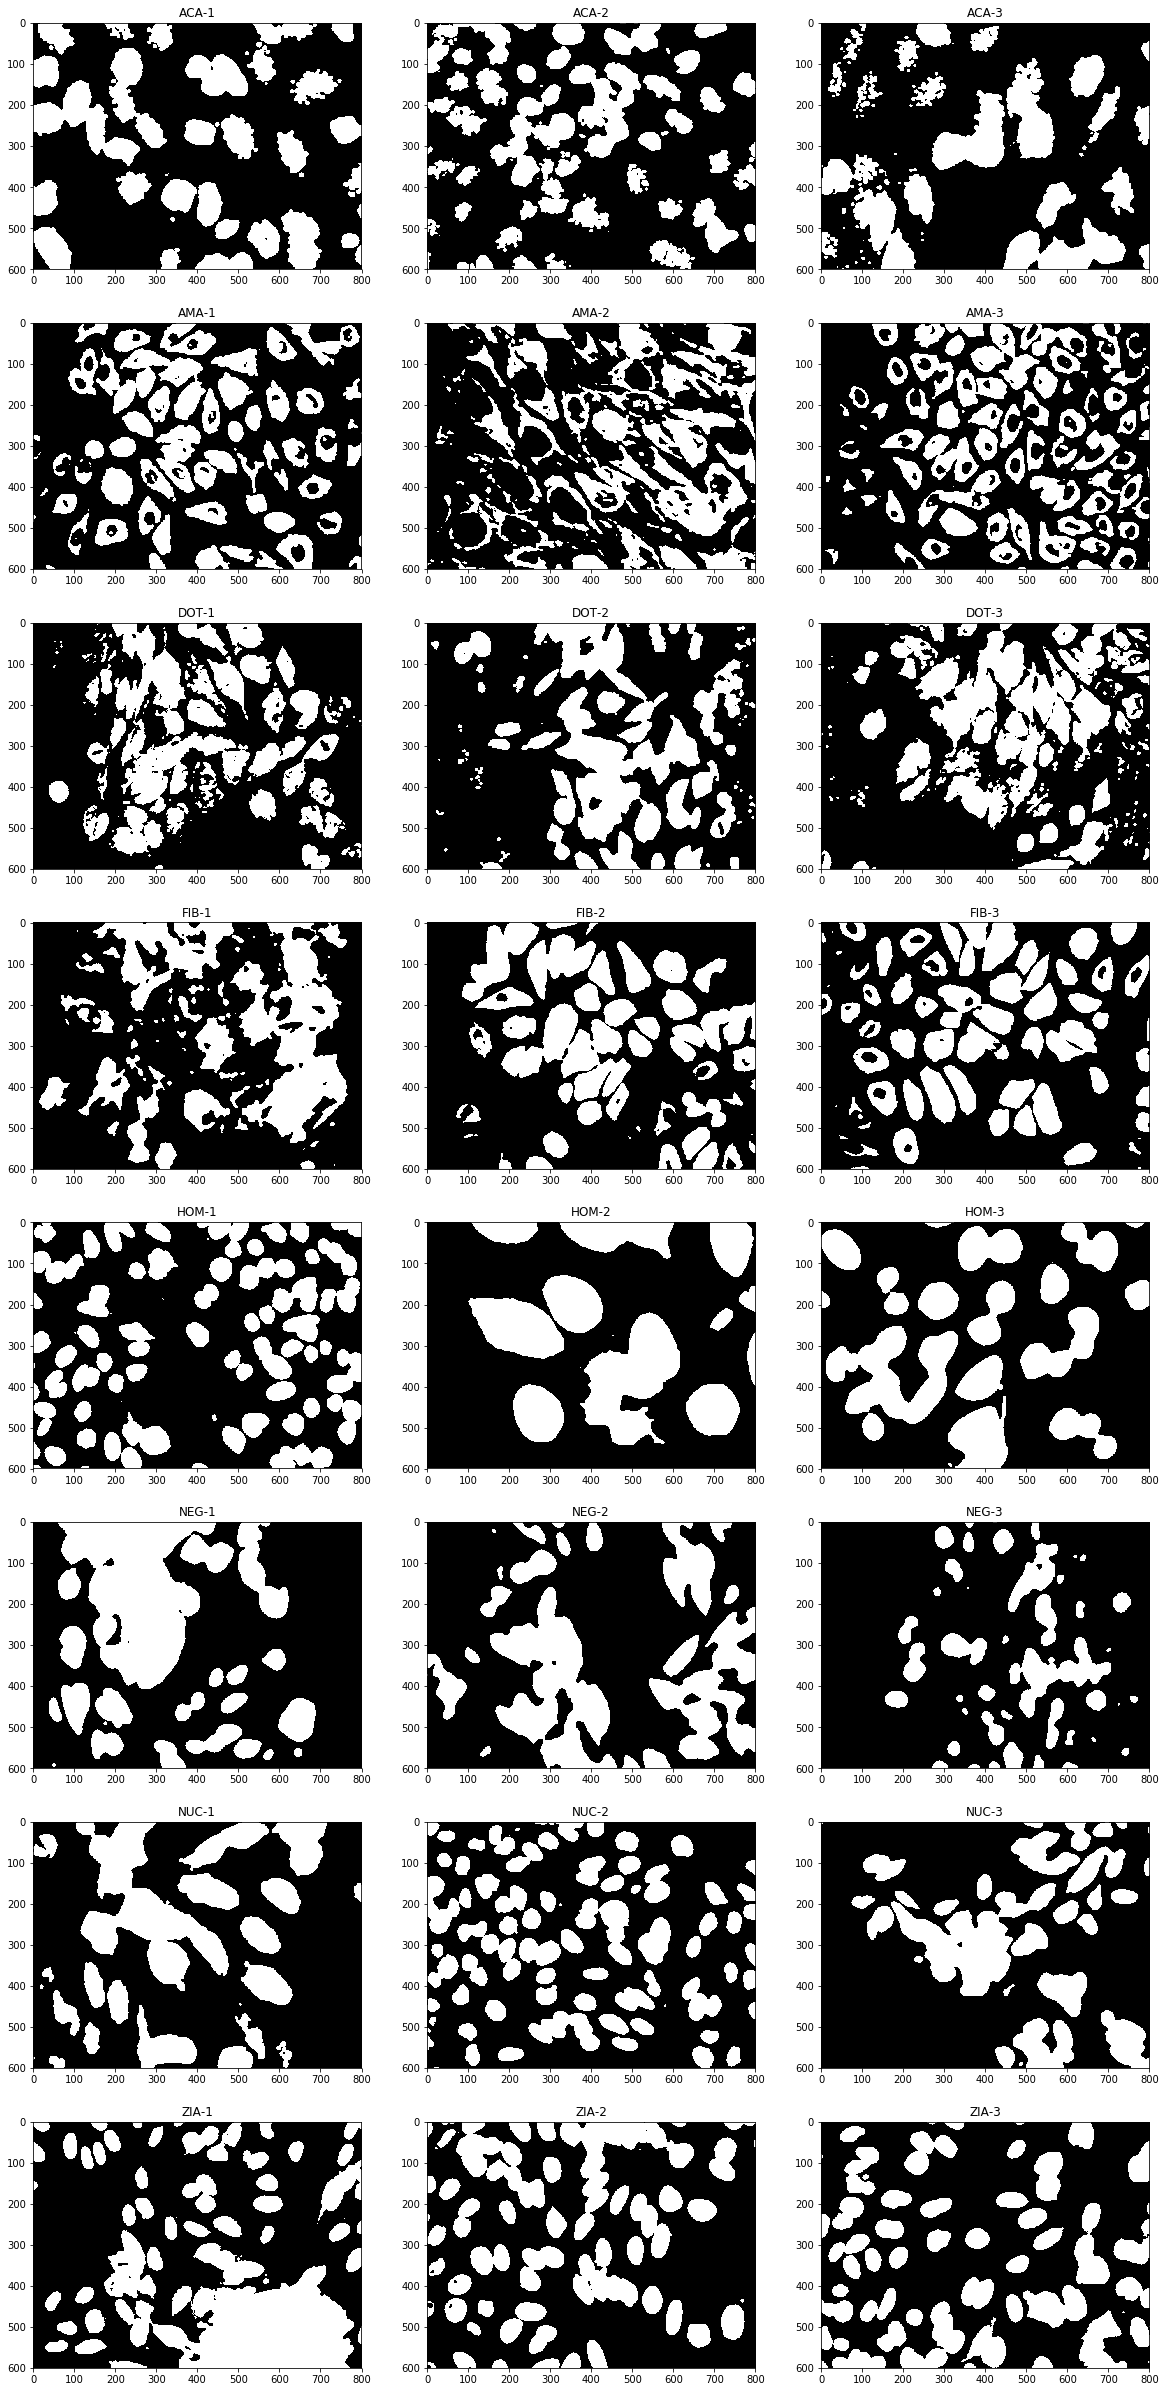

In [6]:
threshold = 240
imgs_threshold = [(img > threshold) for img in imgs_kernel]
display_grid(imgs_threshold, ImagePlotter(), titles)

### Morphological closing 

In [7]:
imgs_morph = [cv.morphologyEx(img.astype('uint8'), cv.MORPH_CLOSE, kernel) for img in imgs_threshold]
display_grid(imgs_morph, ImagePlotter(), titles)

### Labels

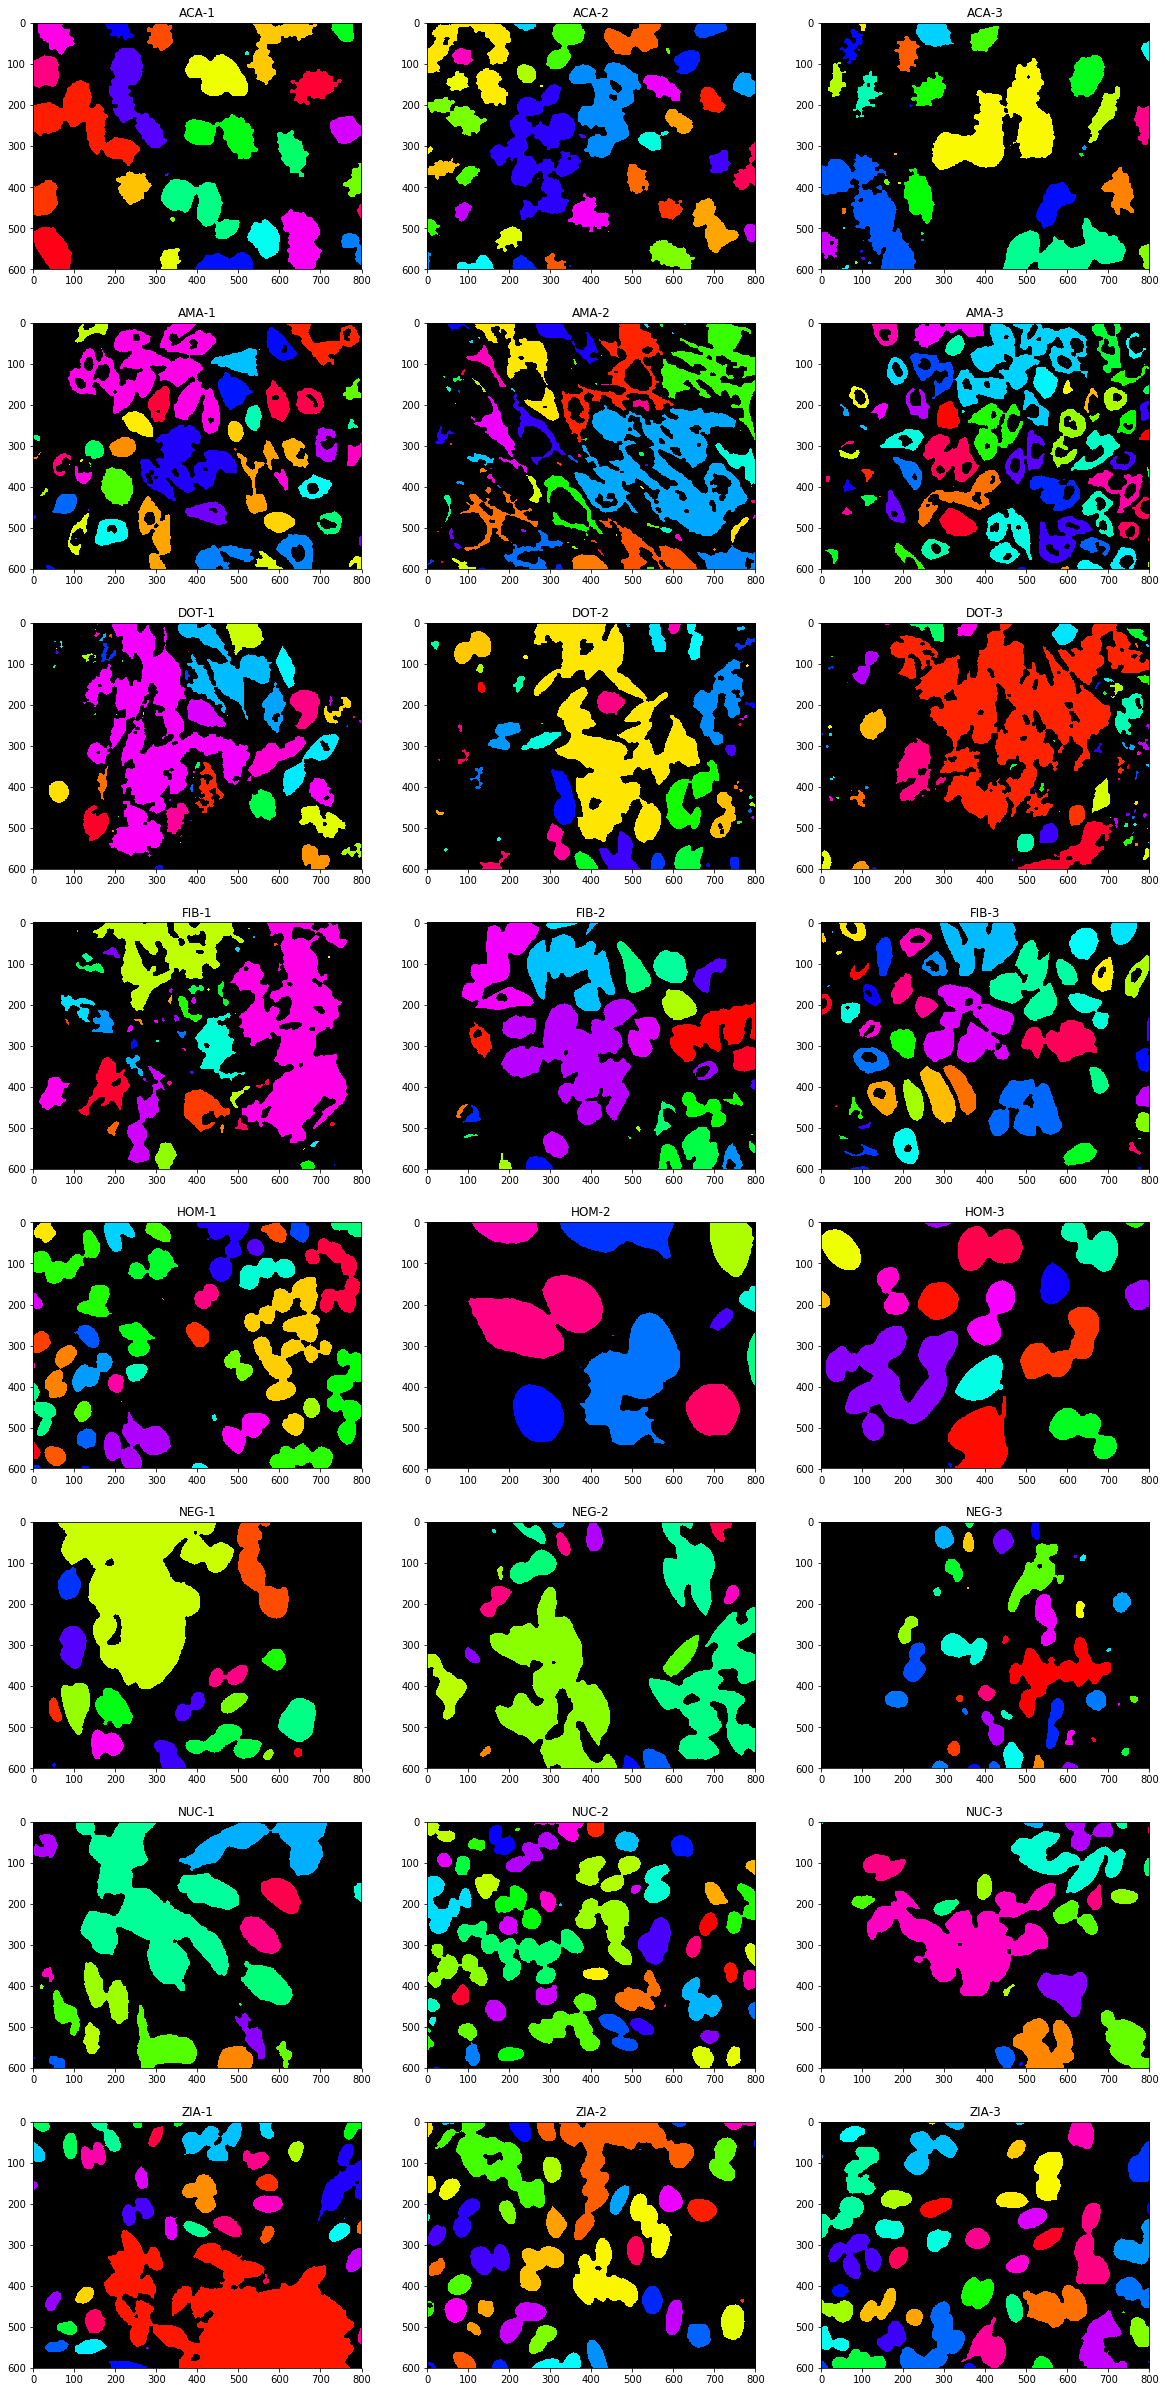

In [8]:
imgs_labeled = [measure.label(img) for img in imgs_morph]
display_grid(imgs_labeled, ImagePlotter(cmap=RANDOM_CMAP), titles)

### Distance transform

In [9]:
imgs_dists = [distance_transform_edt(img > 0) for img in imgs_labeled]
display_grid(imgs_dists, ImagePlotter(), titles)

### Filtering distance transform maximas

In [88]:
def find_local_maxima(arr, footprint, fraction=0.99, global_threshold=10, connect_dist=10):
    maxed = maximum_filter(arr, footprint=footprint, mode='reflect')
    foreground_mask = arr > global_threshold
    
    peaks = (arr >= fraction * maxed) * foreground_mask
    
    dilation_struct = cv.getStructuringElement(cv.MORPH_ELLIPSE, (connect_dist, connect_dist))
    peaks_dilated = cv.morphologyEx(peaks.astype('uint8'), cv.MORPH_DILATE, dilation_struct)
    return peaks_dilated * foreground_mask

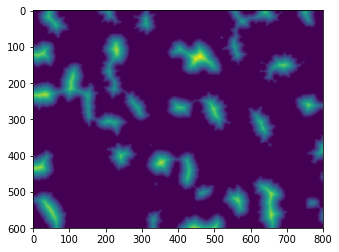

In [89]:
struct = cv.getStructuringElement(cv.MORPH_ELLIPSE, (9,9))
img = imgs_dists[0]

plt.imshow(img)

19528

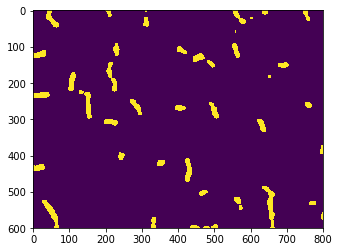

In [93]:
fp = cv.getStructuringElement(cv.MORPH_ELLIPSE, (21,21))

a = find_local_maxima(img, fp, fraction=0.9)
# plt.figure(figsize=(30, 18))
plt.imshow(a)
np.sum(a)

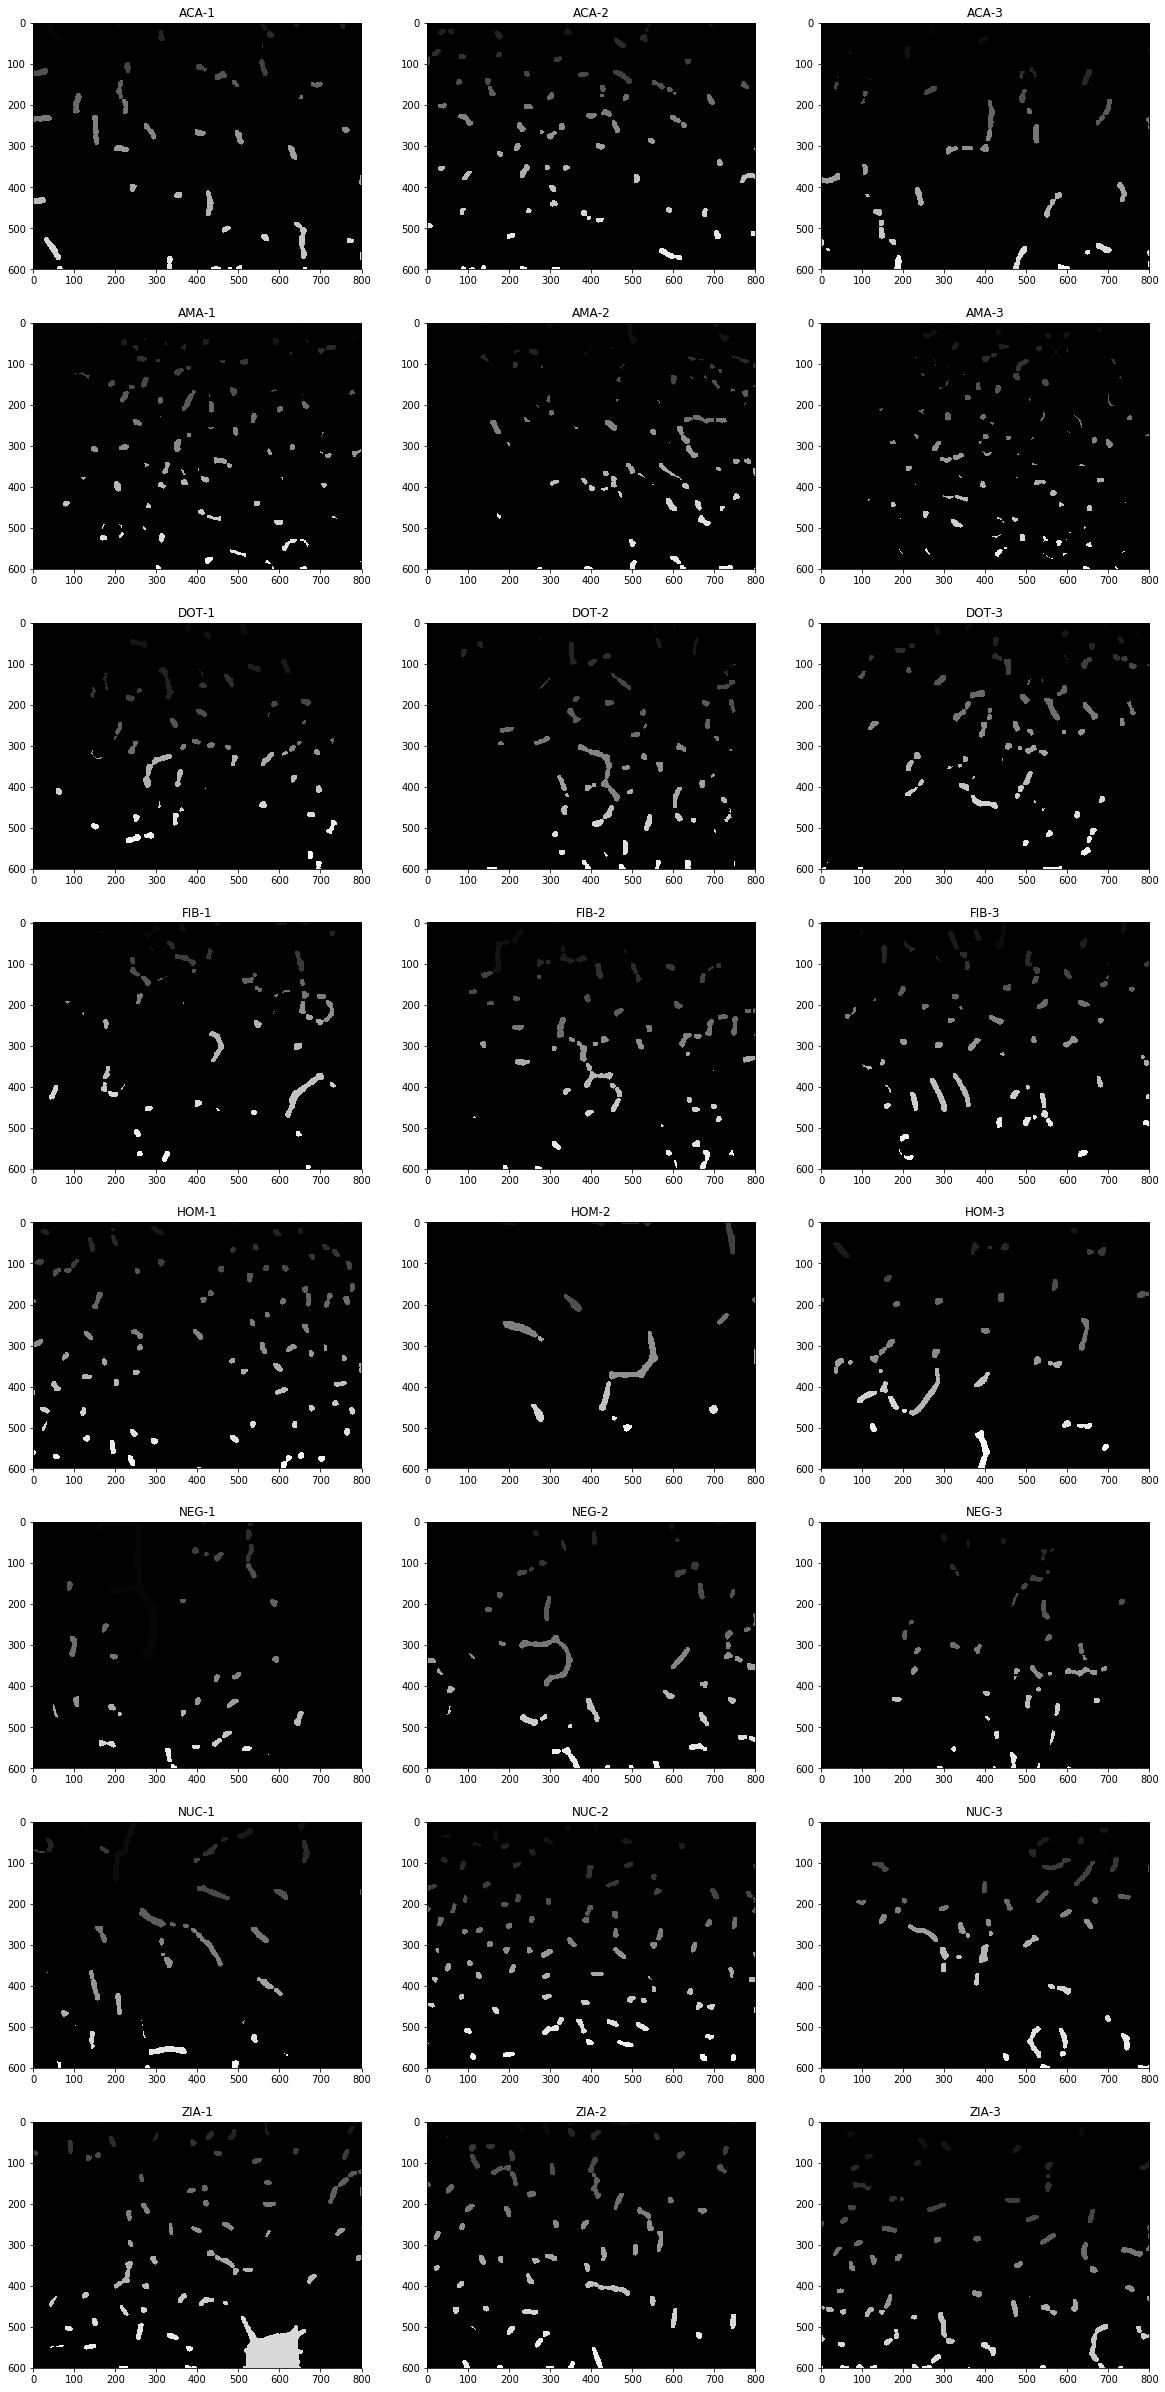

In [73]:
props = [measure.regionprops(l) for l in imgs_labeled]

fp = cv.getStructuringElement(cv.MORPH_ELLIPSE, (21,21))
struct = np.ones((3, 3))

imgs_dist_peaks_markers = []

for img_props, dist in zip(props, imgs_dists):

    local_maxes = find_local_maxima(dist, fp, fraction=0.92)
#     local_maxes = feature.peak_local_max(dist, indices=False, min_distance=20)
    labeled_maxes = label(local_maxes, structure=struct)[0]
        
    imgs_dist_peaks_markers.append(labeled_maxes)
    
display_grid(imgs_dist_peaks_markers, ImagePlotter(), titles)

### Watershed segmentation

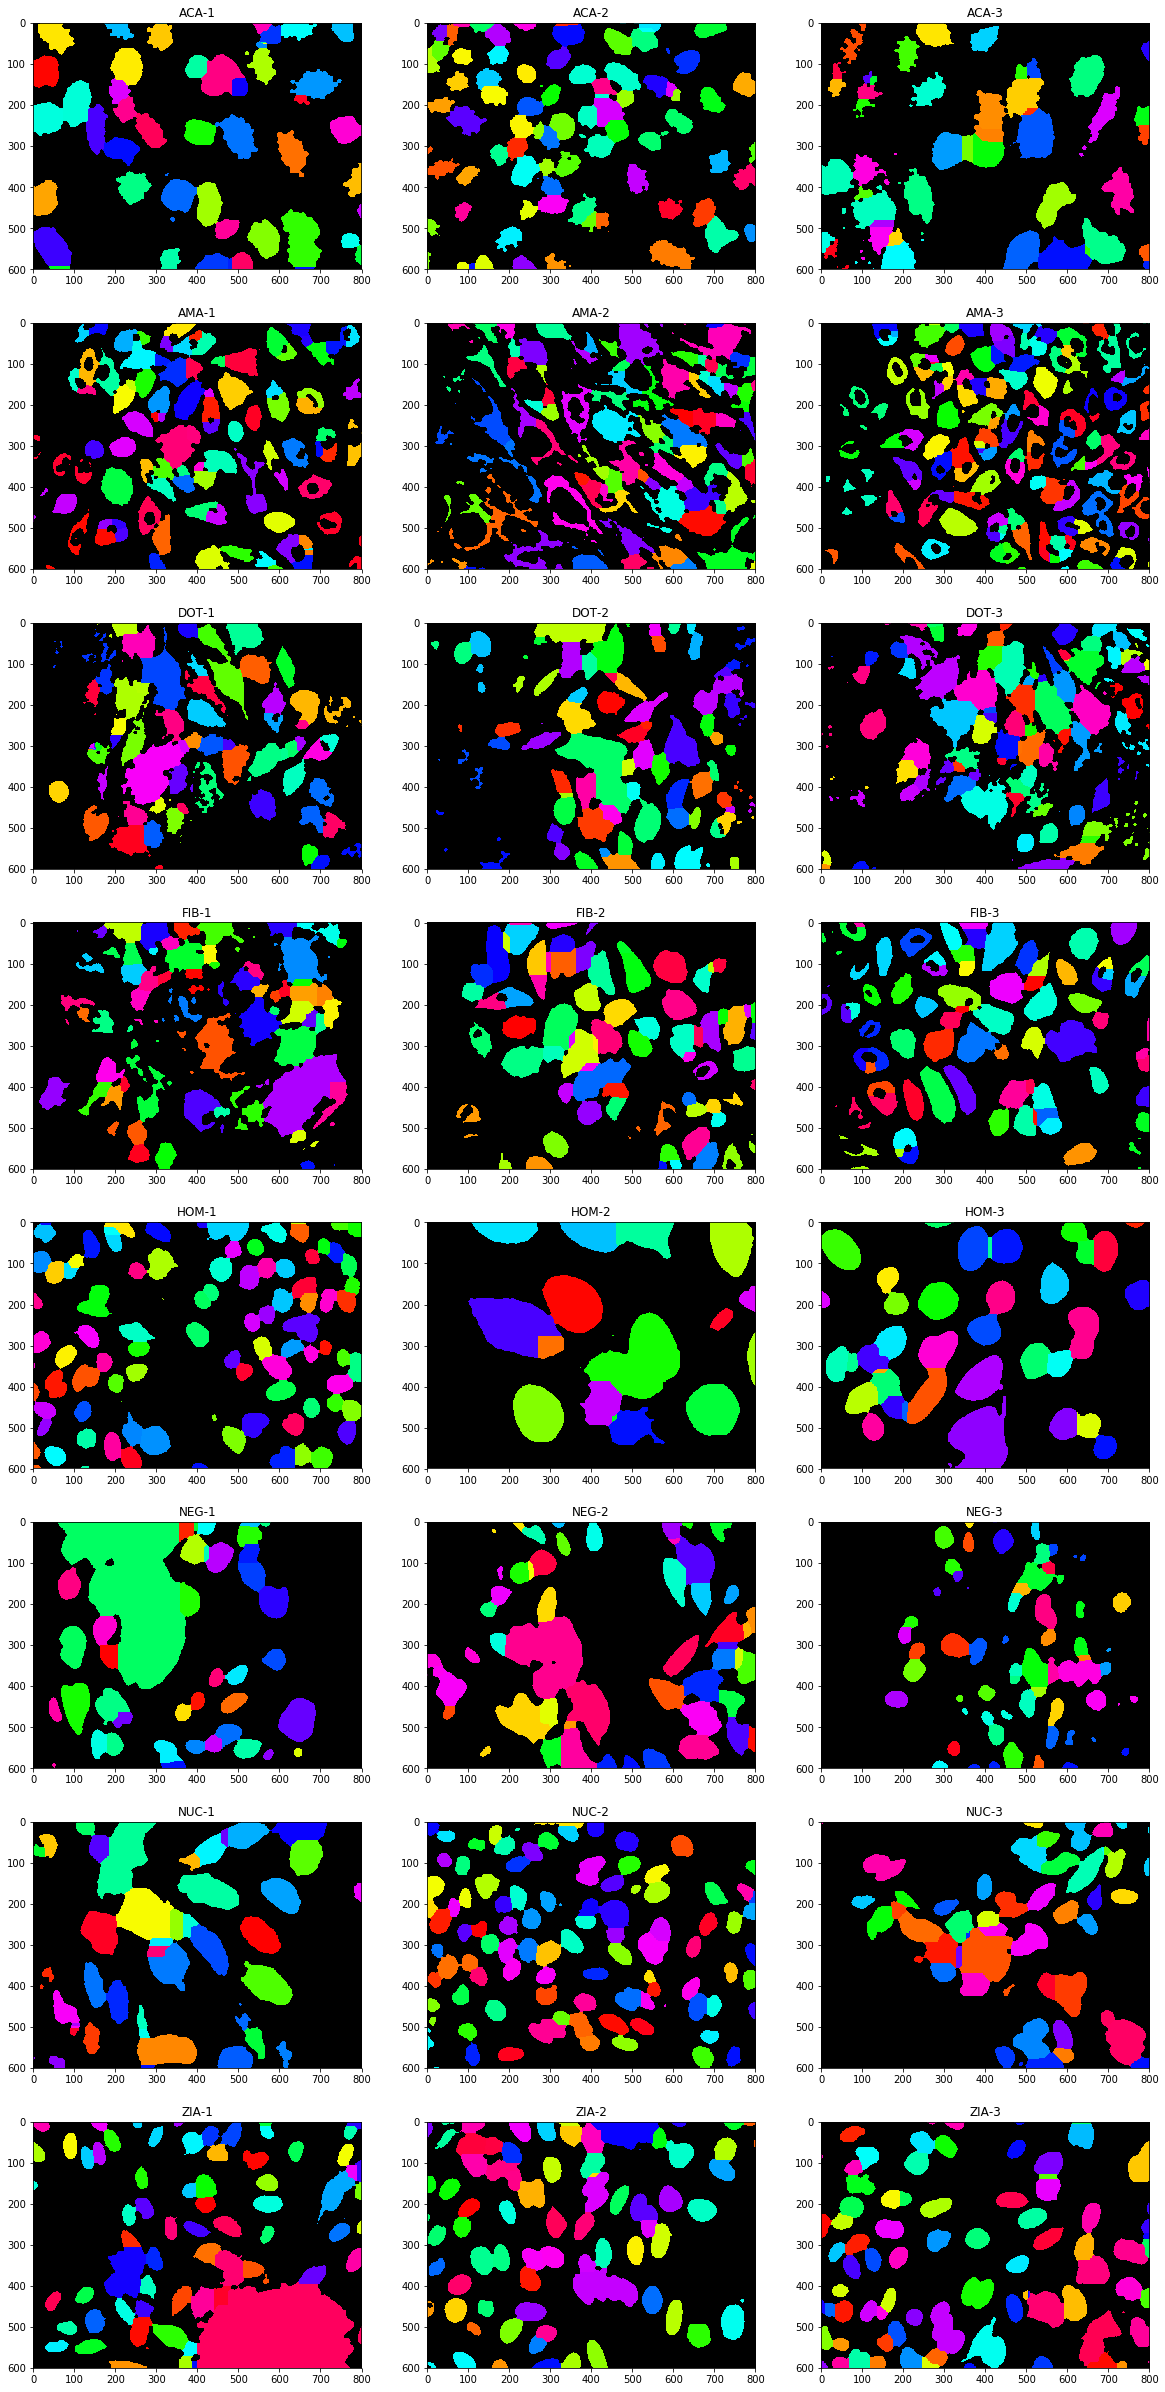

In [74]:
imgs_watershed = []

for (peaks_markers, dists) in zip(imgs_dist_peaks_markers, imgs_dists):
    _, markers = cv.connectedComponents(peaks_markers.astype(np.uint8))
    water = morphology.watershed(-dists, markers)
    imgs_watershed.append(water * (dists > 0))
    
display_grid(imgs_watershed, ImagePlotter(cmap=RANDOM_CMAP), titles)

### drawing cells contours

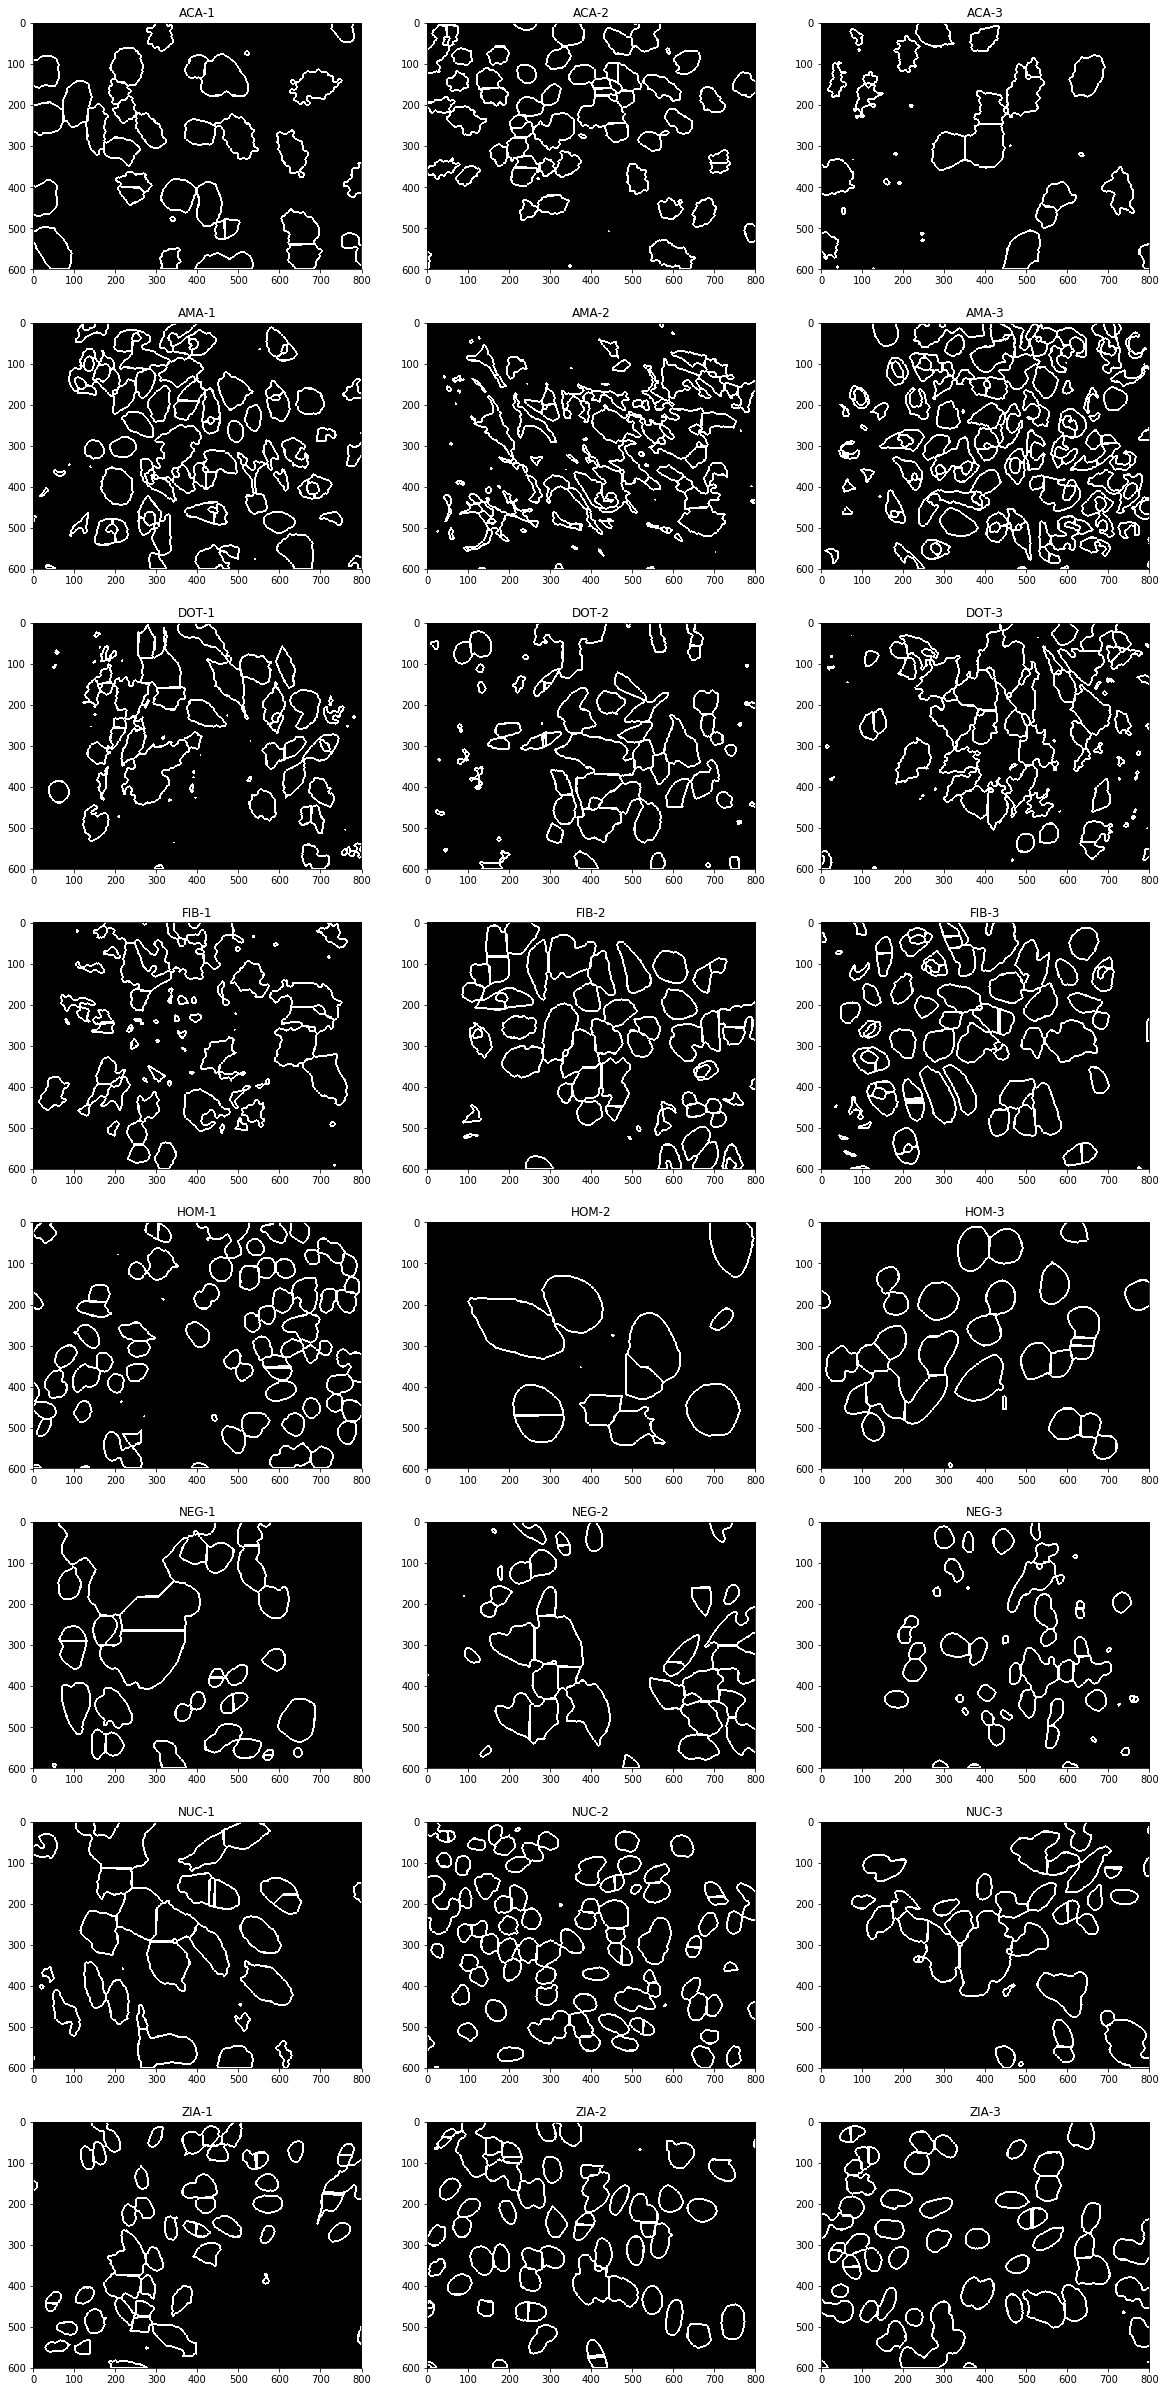

In [12]:
cells_contours = []

for watershed in imgs_watershed:
    regions = measure.regionprops(watershed)
    contour_img = np.zeros(watershed.shape)
    
    for r in regions:
        region_mask = watershed == r.label
        region_contour, _ = cv.findContours(region_mask.astype(np.uint8),
                                            cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cv.drawContours(contour_img, region_contour, 0, 1, 3)
        
    cells_contours.append(contour_img)
    
display_grid(cells_contours, ImagePlotter(), titles)

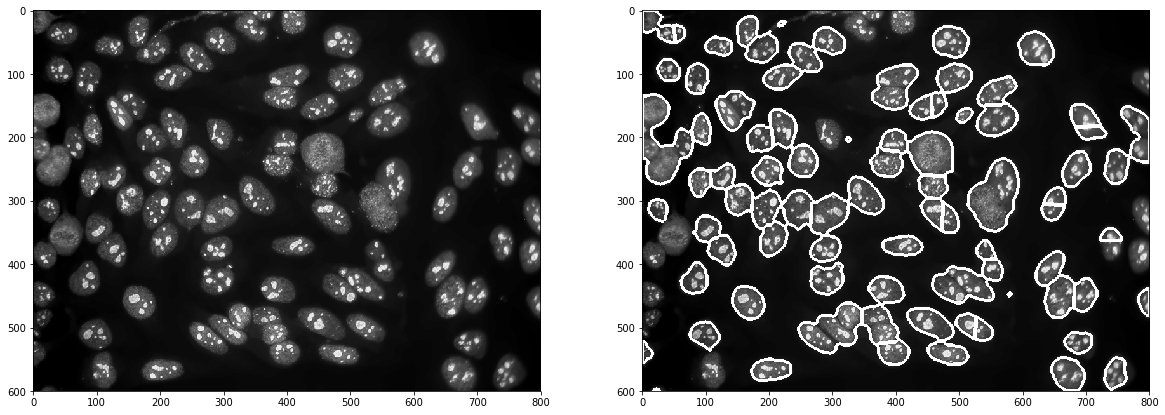

In [13]:
idx = 19
data = imgs[idx]
contour = cells_contours[idx]
f, a = plt.subplots(1, 2)
f.set_size_inches((20, 15))
a[0].imshow(data, cmap='gray')

covered = data.copy()
covered[contour > 0] = 255

a[1].imshow(covered, cmap='gray')

## Morphological snakes

In [75]:
def apply_snakes(img, img_watershed, sigma, iters, balloon=1, threshold=0.6, smoothing=0):
    gradient = gaussian_gradient_magnitude(img.astype(np.float32), sigma=sigma)
    
    cells = [
        morphological_geodesic_active_contour(
            gradient, iters, img_watershed == region_idx, smoothing=smoothing,
            balloon=balloon, threshold=threshold
        ) for region_idx in range(1, np.amax(img_watershed))
    ]
    
    return cells

In [76]:
%%time
snakes_cells = [apply_snakes(img, img_watershed, sigma=5, iters=5)
                for img, img_watershed in zip(imgs, imgs_watershed)]

CPU times: user 2min 28s, sys: 224 ms, total: 2min 28s
Wall time: 2min 28s


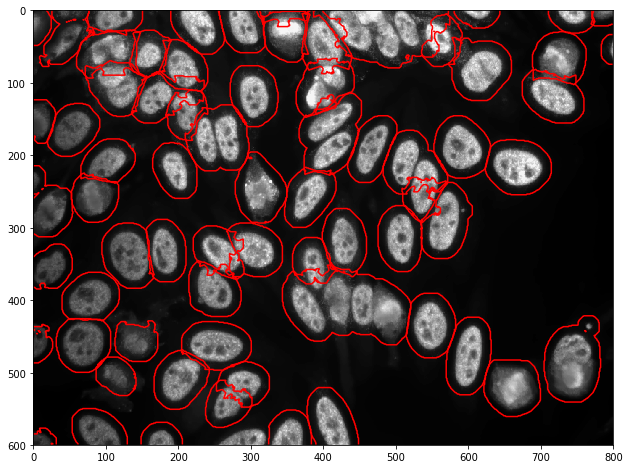

In [84]:
img_index = -2

plt.figure(figsize=(12, 8))

plt.imshow(imgs[img_index], cmap="gray")

for c in snakes_cells[img_index]:
    plt.contour(c, [0.5], colors='r')

In [32]:
%%time
test_idx = 10
test_snakes = apply_snakes(imgs[test_idx], imgs_watershed[test_idx], sigma=5, iters=5, smoothing=1)

plt.figure(figsize=(12, 8))

plt.imshow(imgs[test_idx], cmap="gray")

for c in test_snakes:
    plt.contour(c, [0.5], colors='r')

CPU times: user 16.7 s, sys: 20 ms, total: 16.7 s
Wall time: 16.7 s
